# Notebook to make plots for figure 4

by Cascade Tuholske 2020.04.06

**Pick a city of geography & Year ... 1987-1988 W Africa, 1998 India & 2003 Europe** <br>
Cities : 12080 Hongcong, 9691 Kolkata, 8050 Bangalore, 1910 Accra, 2125 Lagos, 2046 Paris, 2987 Rome,
2559 Milan, 1887 bordeaux, 2135 Brussels, <br>

**We're using**
- 9691, Kolkata 1998
- 2046, Paris 2003
- 4417, Aleppo 2010

Helpful for julian days: https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html

In [1]:
#### Dependencies
import glob
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdates


In [2]:
#### Heat Index Data 
DATA_IN = '/home/cascade/projects/UrbanHeat/data/interim/ERA5_HI/' # output from avg temp
FIG_OUT = '/home/cascade/projects/UrbanHeat/figures/'
DS = u"\N{DEGREE SIGN}"

In [3]:
def make_data(dir_in, geog, location):
    """Function makes data to plot daily city-level HI Max and average
    Args:
        dir_in = directory to get data
        geog = column for geography, city-level = 'ID_HDC_G0'
        location = usually a city id
    """
    
    fn_list = sorted(glob.glob(dir_in+'*.csv')) # get data
    df_out = pd.DataFrame() # to write dataframe
    
     # get leap year cols from 2016
    hi16 = pd.read_csv(fn_list[33]) 
    cols = list(hi16.iloc[:,3:].columns)
    cols = [year[5:] for year in cols] # cols for data frame
    
    temp_list = [] # empty list for temps
    
    # loop through dir and get data
    for i, fn in enumerate(fn_list):
        df = pd.read_csv(fn) # open data frame
        year_label = [(df.columns[3]).split('.')[0]] # get year
        row = df[df[geog] == location]
        temp = row.iloc[:,3:] # get only temp columns
        
        # add in col for leap years
        if temp.shape[1] == 365:
            temp.insert(loc = 59, column = year_label[0]+'.02.29', value = np.nan, allow_duplicates=False)

        # Set Index & Columns
        temp.index = year_label
        temp.columns = cols # revalue to m.d
    
        # add to list
        temp_list.append(temp)
    
    df_out = pd.concat(temp_list) # make one big dataframe
    
    return df_out
    

In [4]:
def plot_data(df, year, start, end):#, start, end):
    """ Make the data for a plot
    Args: 
        df = df w/ daily HI max for a given city
        year = year you want to plot against average
        start = start of plot in julian days (e.g 1 - 365/366)
        end = end of plot in julian days
    """

    # Deal with leap year
    if year % 4 !=0:
        df.drop(columns ='02.29', inplace = True)
    
    # Subset data
    start = start - 1 # zero indexing 
    subset = df.iloc[:,start:end]
    
    # HI Max for year
    hi_year = subset.loc[str(year)]
    
    # make 34-avg daily hi
    means = subset.mean(axis = 0)
    
    # make colums to date time
    cols = pd.to_datetime([str(year)+'.'+date for date in hi_year.index])
    
    return hi_year, means, cols


# One panel

In [153]:
# Args
#[3342, 'Cairo'] #[1910, 'Accra'] 3268, Cape Town

city_list = [4417, 'Aleppo']# [2046, 'Paris']# [4417, 'Aleppo'] # [4337, 'Beruit'] 
year = 2010
font_size = 9

# April 1 to Sep 30 (Use Julian Days), or 1 - 182 lagos
start = 91 
end = 273

# Labels
hi_label = str(year)+' HI'
labels =  ['avg. HI', hi_label, '40.6 '+DS+'C']

# Make Data 
data = make_data(DATA_IN, 'ID_HDC_G0', city_list[0])
hi_year, means,cols = plot_data(data, year, start, end)

# FN OUT
FN_OUT = 'FIG4-Aleppo10.png'

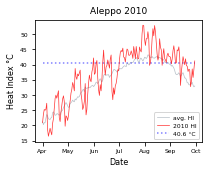

In [154]:
#### Make Figure & Save it

# Set up
rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 
fig, axs = plt.subplots(1, 1, figsize = (3, 2.247), sharex=True) #(3, 2.247)
ws = 0.5
fig.subplots_adjust(hspace=ws)

#plot
axs.plot(cols, means, color = 'slategray', alpha = 0.5, linestyle = '-', lw = 0.7) # Long term daily avg
axs.plot(cols, hi_year, color = 'red', alpha = 0.8, lw = 0.7) # Daily HI Max
axs.hlines(y = 40.6, xmin = min(cols), xmax = max(cols), alpha = 0.5, linestyle = ':', color = 'blue')
axs.set_title(city_list[1]+' '+str(year), fontsize = font_size)
axs.tick_params(axis='both', labelsize = 6)

# ticks
# Make ticks on occurrences of each month:
axs.xaxis.set_major_locator(mdates.MonthLocator())
axs.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axs.tick_params(axis='both', labelsize = 6)
#axs.xaxis.set_major_locator(plt.MaxNLocator(3))

# Labels
#fig.text(0,0.5, 'Heat Index '+DS+'C', ha="center", va="center", rotation=90, fontsize = 8)
plt.ylabel('Heat Index '+DS+'C', fontsize = 8)
plt.xlabel('Date', fontsize = 8)


# Legend
plt.legend(labels, loc=4, prop={'size': 6})

# Save it out
#plt.savefig(FIG_OUT+FN_OUT, dpi = 300, bbox_inches='tight')

In [108]:
#### Always double check dates are correct
cols

DatetimeIndex(['2003-04-01', '2003-04-02', '2003-04-03', '2003-04-04',
               '2003-04-05', '2003-04-06', '2003-04-07', '2003-04-08',
               '2003-04-09', '2003-04-10',
               ...
               '2003-09-21', '2003-09-22', '2003-09-23', '2003-09-24',
               '2003-09-25', '2003-09-26', '2003-09-27', '2003-09-28',
               '2003-09-29', '2003-09-30'],
              dtype='datetime64[ns]', length=183, freq=None)

#### Look at data

In [115]:
# Find Heat Wave From All DATA
def select_city_year(df, city_id, year):
    "Quick search to find city and years within HI_STATS"
    df_out = df[(df['ID_HDC_G0'] == city_id) & (df['year'] == year)]
    
    return df_out

meta_fn = '/home/cascade/projects/UrbanHeat/data/processed/AllDATA-GHS-ERA5-HI406-META.csv'
ALL_DATA = pd.read_csv(meta_fn)

# City Aleppo event is [669069]
city = select_city_year(ALL_DATA, 9691, 1998)
city

,Unnamed: 0,Unnamed: 0.1,ID_HDC_G0,CTR_MN_NM,total_days,duration,avg_temp,avg_intensity,tot_intensity,event_dates,intensity,tmax,year,Event_ID,region,sub-region,intermediate-region,GCPNT_LAT,GCPNT_LON
1973237,1973237,68368,9691,India,196,3,42.808524,2.208524,6.625571,['1998.03.21' '1998.03.22' '1998.03.23'],[0.232936 5.64080135 0.75183391],[40.832936 46.24080135 41.35183391],1998,2566948,Asia,Southern Asia,Southern Asia,22.524884,88.292496
1973238,1973238,68369,9691,India,196,1,43.321827,2.721827,2.721827,['1998.03.29'],[2.72182692],[43.32182692],1998,2566949,Asia,Southern Asia,Southern Asia,22.524884,88.292496
1973239,1973239,68370,9691,India,196,30,46.223850,5.623850,168.715490,['1998.04.05' '1998.04.06' '1998.04.07' '1998....,[ 0.92215666 3.17212961 4.59643837 5.892981...,[41.52215666 43.77212961 45.19643837 46.492981...,1998,2566950,Asia,Southern Asia,Southern Asia,22.524884,88.292496
1973240,1973240,68371,9691,India,196,5,46.396053,5.796053,28.980265,['1998.05.06' '1998.05.07' '1998.05.08' '1998....,[4.48711742 9.01836639 4.95226974 6.75791414 3...,[45.08711742 49.61836639 45.55226974 47.357914...,1998,2566951,Asia,Southern Asia,Southern Asia,22.524884,88.292496
1973241,1973241,68372,9691,India,196,93,49.318453,8.718453,810.816129,['1998.05.12' '1998.05.13' '1998.05.14' '1998....,[ 2.25998033 1.83447001 4.44987329 6.279120...,[42.85998033 42.43447001 45.04987329 46.879120...,1998,2566952,Asia,Southern Asia,Southern Asia,22.524884,88.292496
1973242,1973242,68373,9691,India,196,4,45.945755,5.345755,21.383020,['1998.08.14' '1998.08.15' '1998.08.16' '1998....,[5.03853307 3.21779862 8.7605059 4.36618281],[45.63853307 43.81779862 49.3605059 44.96618281],1998,2566953,Asia,Southern Asia,Southern Asia,22.524884,88.292496
1973243,1973243,68374,9691,India,196,8,47.981101,7.381101,59.048810,['1998.08.19' '1998.08.20' '1998.08.21' '1998....,[7.0749151 3.78110136 9.26930569 9.10029719 9...,[47.6749151 44.38110136 49.86930569 49.700297...,1998,2566954,Asia,Southern Asia,Southern Asia,22.524884,88.292496
1973244,1973244,68375,9691,India,196,11,46.314605,5.714605,62.860651,['1998.08.28' '1998.08.29' '1998.08.30' '1998....,[5.84873862 3.69605181 7.88442719 4.94905184 5...,[46.44873862 44.29605181 48.48442719 45.549051...,1998,2566955,Asia,Southern Asia,Southern Asia,22.524884,88.292496
1973245,1973245,68376,9691,India,196,1,41.562063,0.962063,0.962063,['1998.09.09'],[0.96206262],[41.56206262],1998,2566956,Asia,Southern Asia,Southern Asia,22.524884,88.292496
1973246,1973246,68377,9691,India,196,31,48.354347,7.754347,240.384764,['1998.09.14' '1998.09.15' '1998.09.16' '1998....,[ 5.97008608 8.88279392 9.51982714 7.691916...,[46.57008608 49.48279392 50.11982714 48.291916...,1998,2566957,Asia,Southern Asia,Southern Asia,22.524884,88.292496


In [155]:
# Make a def
df = pd.DataFrame()
df = df.append(means, ignore_index=True)
df = df.append(hi_year, ignore_index=True)
df.columns = cols
df

,2010-04-01,2010-04-02,2010-04-03,2010-04-04,2010-04-05,2010-04-06,2010-04-07,2010-04-08,2010-04-09,2010-04-10,...,2010-09-21,2010-09-22,2010-09-23,2010-09-24,2010-09-25,2010-09-26,2010-09-27,2010-09-28,2010-09-29,2010-09-30
0,21.184140,20.252151,20.938472,20.850237,22.351843,23.581947,23.104296,22.145631,22.024662,21.939870,...,33.988790,34.024778,33.360232,33.314841,33.394788,33.810165,34.140988,33.196777,32.673420,32.947520
1,20.921927,23.587167,25.233480,24.990045,25.283789,27.281672,18.637575,16.443057,17.846010,19.074826,...,39.427714,37.705600,38.489211,38.200101,32.724765,34.558024,38.553412,35.733119,38.592777,41.188774


In [157]:
# Isloate daily HI vs averages Kolkata [:,57:71] Paris [:,122:140] Aleppo[:,92: 92+36]
wave = df.iloc[:,92: 92+36] # [:,122:140]#[:,57:71] #[:,92: 92+36]
wave = wave.transpose()
wave.columns = ['mean', 'HI']
wave['hi_dif'] = wave['HI'] - wave['mean'] 
print(wave['hi_dif'].mean())
wave

4.280068902132884


,mean,HI,hi_dif
2010-07-02,38.743860,41.657143,2.913282
2010-07-03,38.615228,43.946223,5.330994
2010-07-04,38.576589,44.625811,6.049223
2010-07-05,38.712376,44.185450,5.473074
2010-07-06,39.099951,45.396693,6.296742
2010-07-07,39.421203,42.457620,3.036416
2010-07-08,39.599409,42.243359,2.643950
2010-07-09,39.480105,40.816456,1.336350
2010-07-10,39.307880,43.252088,3.944208
2010-07-11,40.397767,45.092903,4.695136


In [152]:
116 - 78

38

# Two panel

In [ ]:
#### Make Figure & Save it

#### Args
city_list = [tuple((2045, 'Paris')), tuple((2145, 'Brussels'))]
year = 2003
font_size = 9

# April 1 to Sep 30 Use Julian Days

start = 93 
end = 274

# Labels
hi_label = str(year)+' max HI'
labels = [hi_label, 'mean max HI', '40.6 C']

# Set up
rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 
fig, axs = plt.subplots(2, 1, figsize = (3, 2), sharex=True)
ws = 0.5
fig.subplots_adjust(hspace=ws)

## Plot 1 
data = make_data(DATA_IN, 'ID_HDC_G0', city_list[0][0])
hi_year, means,cols = plot_data(data, year, start, end) 
axs[0].plot(cols, hi_year, color = 'red', alpha = 0.7) # Daily HI Max
axs[0].plot(cols, means, color = 'black', alpha = 0.5, linestyle = 'solid') # Long term daily avg
axs[0].hlines(y = 40.6, xmin = min(cols), xmax = max(cols), alpha = 0.5, linestyle = ':', color = 'blue')
axs[0].set_title(city_list[0][1]+' '+str(year), fontsize = font_size)
axs[0].tick_params(axis='both', labelsize = 6)

## Plot 2 
data = make_data(DATA_IN, 'ID_HDC_G0', city_list[1][0])
hi_year, means, cols = plot_data(data, year, start, end) 
axs[1].plot(cols, hi_year, color = 'red', alpha = 0.7) # Daily HI Max
axs[1].plot(cols, means, color = 'black', alpha = 0.5, linestyle = 'solid') # Long term daily avg
axs[1].hlines(y = 40.6, xmin = min(cols), xmax = max(cols), alpha = 0.5, linestyle = ':', color = 'blue')
axs[1].set_title(city_list[1][1]+' '+str(year), fontsize = font_size)

# ticks
# Make ticks on occurrences of each month:
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axs[1].tick_params(axis='both', labelsize = 6)
#axs[1].xaxis.set_major_locator(plt.MaxNLocator(3))

# Labels
fig.text(0,0.5, "Heat Index C", ha="center", va="center", rotation=90, fontsize = 8)
plt.xlabel('Date', fontsize = 8)


# Legend
plt.legend(labels, loc=2, prop={'size': 4})

# Save it out
plt.savefig(FIG_OUT+'TEST.png', dpi = 300, bbox_inches='tight')
